#Experimento 5 - Multiclassificação de distúrbios pulmonares
***
- Conjunto de Dados: CheXpert Dataset
- Modelos Retreinados: [DenseNet121, InceptionV3, Xception, InceptionResNetV2, MobileNetV2]

### Importação dos pacotes necessários
***

#### Pacotes utilitários
***

In [ ]:
!pip install lungs_segmentation

In [1]:
import urllib.request as url
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import cv2
from sklearn.model_selection import train_test_split
from bbox_delimiters import bbox_utils
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, average_precision_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, multilabel_confusion_matrix

#### Framework Tensorflow
***

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet_v2 import ResNet101V2
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

### Baixando os dados do Kaggle
***
- [CheXpert Dataset](https://www.kaggle.com/awsaf49/chexpert-dataset)

In [ ]:
drive.mount('/content/gdrive', force_remount = True)
!cp -r /content/gdrive/MyDrive/chexpert-v10-small.zip /content/
!unzip /content/chexpert-v10-small.zip
!rm /content/chexpert-v10-small.zip

### Pré-processamento nos dados
***

In [90]:
image_size = 256
batch_size = 32

In [17]:
df = pd.read_csv('/content/CheXpert-v1.0-small/train.csv', delimiter = ',')

In [18]:
df.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


In [19]:
labels = ['Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation',
          'Atelectasis', 'Pneumothorax', 'Pleural Effusion']

In [20]:
labels_portugues = ['Opacidade Pulmonar', 'Lesão Pulmonar', 'Edema',
                    'Consolidação', 'Atelectasia', 'Pneumotórax',
                    'Efusão Pleural']

In [21]:
print(df['Frontal/Lateral'].value_counts())
df = df[df['Frontal/Lateral'] == 'Frontal'].copy()
df.drop(labels = 'Frontal/Lateral', axis = 1, inplace = True)

Frontal    191027
Lateral     32387
Name: Frontal/Lateral, dtype: int64


In [22]:
df.drop(labels = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly',
                  'Fracture', 'Support Devices'], axis = 1, inplace = True)

In [23]:
print(df['AP/PA'].value_counts())
df = df[(df['AP/PA'] == 'AP') |
        (df['AP/PA'] == 'PA')].copy()
df.drop(labels = 'AP/PA', axis = 1, inplace = True)

AP    161590
PA     29420
LL        16
RL         1
Name: AP/PA, dtype: int64


In [24]:
print(df['Age'].describe())
df = df[(df['Age'] <= 80) |
        (df['Age'] >= 10)]
df.drop(labels = 'Age', axis = 1, inplace = True)

count    191010.000000
mean         60.673227
std          17.816772
min           0.000000
25%          49.000000
50%          62.000000
75%          74.000000
max          90.000000
Name: Age, dtype: float64


In [25]:
df.drop(labels=['Sex', 'Pneumonia', 'Pleural Other'], axis=1, inplace=True)

In [26]:
def count_values(dataframe, label):
  df = dataframe[dataframe[label] == 1.0]
  return len(df)

In [27]:
df.replace(to_replace = float('NaN'), value = 0.0, inplace = True)
df.replace(to_replace = -1.0, value = 0.0, inplace = True)

In [28]:
print('{}: {} imagens'.format(labels[0], count_values(df, labels[0])))
print('{}: {} imagens'.format(labels[1], count_values(df, labels[1])))
print('{}: {} imagens'.format(labels[2], count_values(df, labels[2])))
print('{}: {} imagens'.format(labels[3], count_values(df, labels[3])))
print('{}: {} imagens'.format(labels[4], count_values(df, labels[4])))
print('{}: {} imagens'.format(labels[5], count_values(df, labels[5])))
print('{}: {} imagens'.format(labels[6], count_values(df, labels[6])))

Lung Opacity: 94207 imagens
Lung Lesion: 7040 imagens
Edema: 49674 imagens
Consolidation: 12982 imagens
Atelectasis: 29718 imagens
Pneumothorax: 17693 imagens
Pleural Effusion: 76894 imagens


In [29]:
lung_opacity = df[(df[labels[0]] == 1.) &
                  (df[labels[1]] != 1.) &
                  (df[labels[2]] != 1.) &
                  (df[labels[3]] != 1.) &
                  (df[labels[4]] != 1.) &
                  (df[labels[5]] != 1.) &
                  (df[labels[6]] != 1.)].index

lung_lesion = df[(df[labels[0]] != 1.) &
                 (df[labels[1]] == 1.) &
                 (df[labels[2]] != 1.) &
                 (df[labels[3]] != 1.) &
                 (df[labels[4]] != 1.) &
                 (df[labels[5]] != 1.) &
                 (df[labels[6]] != 1.)].index

edema = df[(df[labels[0]] != 1.) &
           (df[labels[1]] != 1.) &
           (df[labels[2]] == 1.) &
           (df[labels[3]] != 1.) &
           (df[labels[4]] != 1.) &
           (df[labels[5]] != 1.) &
           (df[labels[6]] != 1.)].index

consolidation = df[(df[labels[0]] != 1.) &
                   (df[labels[1]] != 1.) &
                   (df[labels[2]] != 1.) &
                   (df[labels[3]] == 1.) &
                   (df[labels[4]] != 1.) &
                   (df[labels[5]] != 1.) &
                   (df[labels[6]] != 1.)].index

atelectasis = df[(df[labels[0]] != 1.) &
                 (df[labels[1]] != 1.) &
                 (df[labels[2]] != 1.) &
                 (df[labels[3]] != 1.) &
                 (df[labels[4]] == 1.) &
                 (df[labels[5]] != 1.) &
                 (df[labels[6]] != 1.)].index

pneumothorax = df[(df[labels[0]] != 1.) &
                  (df[labels[1]] != 1.) &
                  (df[labels[2]] != 1.) &
                  (df[labels[3]] != 1.) &
                  (df[labels[4]] != 1.) &
                  (df[labels[5]] == 1.) &
                  (df[labels[6]] != 1.)].index
  
pleural_effusion = df[(df[labels[0]] != 1.) &
                      (df[labels[1]] != 1.) &
                      (df[labels[2]] != 1.) &
                      (df[labels[3]] != 1.) &
                      (df[labels[4]] != 1.) &
                      (df[labels[5]] != 1.) &
                      (df[labels[6]] == 1.)].index

In [30]:
print('Rotulações individuais:\n')
print('{}: {} imagens'.format(labels_portugues[0], len(lung_opacity)))
print('{}: {} imagens'.format(labels_portugues[1], len(lung_lesion)))
print('{}: {} imagens'.format(labels_portugues[2], len(edema)))
print('{}: {} imagens'.format(labels_portugues[3], len(consolidation)))
print('{}: {} imagens'.format(labels_portugues[4], len(atelectasis)))
print('{}: {} imagens'.format(labels_portugues[5], len(pneumothorax)))
print('{}: {} imagens'.format(labels_portugues[6], len(pleural_effusion)))

Rotulações individuais:

Opacidade Pulmonar: 23005 imagens
Lesão Pulmonar: 1385 imagens
Edema: 9728 imagens
Consolidação: 2570 imagens
Atelectasia: 5088 imagens
Pneumotórax: 5177 imagens
Efusão Pleural: 9214 imagens


In [31]:
df_pure_multilabel = pd.concat((df.drop(lung_opacity), df.drop(lung_lesion),
                                df.drop(edema), df.drop(consolidation),
                                df.drop(atelectasis), df.drop(pneumothorax),
                                df.drop(pleural_effusion)))

In [32]:
print('Imagens que compartilham mais de um rótulo:\n')
print('{}: {} imagens'.format(labels[0], count_values(df_pure_multilabel, labels[0])))
print('{}: {} imagens'.format(labels[1], count_values(df_pure_multilabel, labels[1])))
print('{}: {} imagens'.format(labels[2], count_values(df_pure_multilabel, labels[2])))
print('{}: {} imagens'.format(labels[3], count_values(df_pure_multilabel, labels[3])))
print('{}: {} imagens'.format(labels[4], count_values(df_pure_multilabel, labels[4])))
print('{}: {} imagens'.format(labels[5], count_values(df_pure_multilabel, labels[5])))
print('{}: {} imagens'.format(labels[6], count_values(df_pure_multilabel, labels[6])))

Imagens que compartilham mais de um rótulo:

Lung Opacity: 636444 imagens
Lung Lesion: 47895 imagens
Edema: 337990 imagens
Consolidation: 88304 imagens
Atelectasis: 202938 imagens
Pneumothorax: 118674 imagens
Pleural Effusion: 529044 imagens


In [33]:
ts1 = df_pure_multilabel.sample(n=7040, weights = labels[1], random_state=42)
ts2 = df_pure_multilabel.drop(ts1.index).sample(n=7040, weights = labels[3], random_state=42)
ts3 = df_pure_multilabel.drop(pd.concat([ts1, ts2]).index).sample(n=7040, weights = labels[5], random_state=42)
ts4 = df_pure_multilabel.drop(pd.concat([ts1, ts2, ts3]).index).sample(n=4000, weights = labels[2], random_state=42)
ts5 = df_pure_multilabel.drop(pd.concat([ts1, ts2, ts3, ts4]).index).sample(n=4000, weights = labels[4], random_state=42)

df_more_balanced = pd.concat([ts1,ts2,ts3, ts4, ts5])

In [34]:
print('{}: {} imagens'.format(labels[0], count_values(df_more_balanced, labels[0])))
print('{}: {} imagens'.format(labels[1], count_values(df_more_balanced, labels[1])))
print('{}: {} imagens'.format(labels[2], count_values(df_more_balanced, labels[2])))
print('{}: {} imagens'.format(labels[3], count_values(df_more_balanced, labels[3])))
print('{}: {} imagens'.format(labels[4], count_values(df_more_balanced, labels[4])))
print('{}: {} imagens'.format(labels[5], count_values(df_more_balanced, labels[5])))
print('{}: {} imagens'.format(labels[6], count_values(df_more_balanced, labels[6])))

Lung Opacity: 14445 imagens
Lung Lesion: 7308 imagens
Edema: 8223 imagens
Consolidation: 8072 imagens
Atelectasis: 7788 imagens
Pneumothorax: 8566 imagens
Pleural Effusion: 12939 imagens


In [35]:
lung_opacity = df_more_balanced[(df_more_balanced[labels[0]] == 1.)]
lung_opacity = lung_opacity.sample(n=8000, random_state=42)
df_more_balanced.drop(lung_opacity.index, inplace=True)

In [36]:
print('{}: {} imagens'.format(labels[0], count_values(df_more_balanced, labels[0])))
print('{}: {} imagens'.format(labels[1], count_values(df_more_balanced, labels[1])))
print('{}: {} imagens'.format(labels[2], count_values(df_more_balanced, labels[2])))
print('{}: {} imagens'.format(labels[3], count_values(df_more_balanced, labels[3])))
print('{}: {} imagens'.format(labels[4], count_values(df_more_balanced, labels[4])))
print('{}: {} imagens'.format(labels[5], count_values(df_more_balanced, labels[5])))
print('{}: {} imagens'.format(labels[6], count_values(df_more_balanced, labels[6])))

Lung Opacity: 5034 imagens
Lung Lesion: 4133 imagens
Edema: 5786 imagens
Consolidation: 5954 imagens
Atelectasis: 5645 imagens
Pneumothorax: 5802 imagens
Pleural Effusion: 8671 imagens


In [37]:
pleural_effusion = df_more_balanced[(df_more_balanced[labels[6]] == 1.)]
pleural_effusion = pleural_effusion.sample(n=2671, random_state=42)
df_more_balanced.drop(pleural_effusion.index, inplace=True)

In [38]:
print('{}: {} imagens'.format(labels[0], count_values(df_more_balanced, labels[0])))
print('{}: {} imagens'.format(labels[1], count_values(df_more_balanced, labels[1])))
print('{}: {} imagens'.format(labels[2], count_values(df_more_balanced, labels[2])))
print('{}: {} imagens'.format(labels[3], count_values(df_more_balanced, labels[3])))
print('{}: {} imagens'.format(labels[4], count_values(df_more_balanced, labels[4])))
print('{}: {} imagens'.format(labels[5], count_values(df_more_balanced, labels[5])))
print('{}: {} imagens'.format(labels[6], count_values(df_more_balanced, labels[6])))

Lung Opacity: 4145 imagens
Lung Lesion: 3470 imagens
Edema: 4646 imagens
Consolidation: 4685 imagens
Atelectasis: 4635 imagens
Pneumothorax: 5146 imagens
Pleural Effusion: 5405 imagens


In [39]:
lung_opacity = df[(df[labels[0]] == 1.) &
                  (df[labels[1]] != 1.) &
                  (df[labels[2]] != 1.) &
                  (df[labels[3]] != 1.) &
                  (df[labels[4]] != 1.) &
                  (df[labels[5]] != 1.) &
                  (df[labels[6]] != 1.)]

lung_lesion = df[(df[labels[0]] != 1.) &
                 (df[labels[1]] == 1.) &
                 (df[labels[2]] != 1.) &
                 (df[labels[3]] != 1.) &
                 (df[labels[4]] != 1.) &
                 (df[labels[5]] != 1.) &
                 (df[labels[6]] != 1.)]

edema = df[(df[labels[0]] != 1.) &
           (df[labels[1]] != 1.) &
           (df[labels[2]] == 1.) &
           (df[labels[3]] != 1.) &
           (df[labels[4]] != 1.) &
           (df[labels[5]] != 1.) &
           (df[labels[6]] != 1.)]

consolidation = df[(df[labels[0]] != 1.) &
                   (df[labels[1]] != 1.) &
                   (df[labels[2]] != 1.) &
                   (df[labels[3]] == 1.) &
                   (df[labels[4]] != 1.) &
                   (df[labels[5]] != 1.) &
                   (df[labels[6]] != 1.)]

atelectasis = df[(df[labels[0]] != 1.) &
                 (df[labels[1]] != 1.) &
                 (df[labels[2]] != 1.) &
                 (df[labels[3]] != 1.) &
                 (df[labels[4]] == 1.) &
                 (df[labels[5]] != 1.) &
                 (df[labels[6]] != 1.)]

pneumothorax = df[(df[labels[0]] != 1.) &
                  (df[labels[1]] != 1.) &
                  (df[labels[2]] != 1.) &
                  (df[labels[3]] != 1.) &
                  (df[labels[4]] != 1.) &
                  (df[labels[5]] == 1.) &
                  (df[labels[6]] != 1.)]
  
pleural_effusion = df[(df[labels[0]] != 1.) &
                      (df[labels[1]] != 1.) &
                      (df[labels[2]] != 1.) &
                      (df[labels[3]] != 1.) &
                      (df[labels[4]] != 1.) &
                      (df[labels[5]] != 1.) &
                      (df[labels[6]] == 1.)]

In [40]:
final_df = pd.concat((df_more_balanced, lung_opacity.sample(n=1855, random_state=42), lung_lesion, 
                      edema.sample(n=1354, random_state=42), consolidation.sample(n=1315, random_state=42),
                      atelectasis.sample(n=1364, random_state=42), pneumothorax.sample(n=854, random_state=42),
                      pleural_effusion.sample(n=594, random_state=42)))   

In [41]:
print('{}: {} imagens'.format(labels[0], count_values(final_df, labels[0])))
print('{}: {} imagens'.format(labels[1], count_values(final_df, labels[1])))
print('{}: {} imagens'.format(labels[2], count_values(final_df, labels[2])))
print('{}: {} imagens'.format(labels[3], count_values(final_df, labels[3])))
print('{}: {} imagens'.format(labels[4], count_values(final_df, labels[4])))
print('{}: {} imagens'.format(labels[5], count_values(final_df, labels[5])))
print('{}: {} imagens'.format(labels[6], count_values(final_df, labels[6])))

Lung Opacity: 6000 imagens
Lung Lesion: 4855 imagens
Edema: 6000 imagens
Consolidation: 6000 imagens
Atelectasis: 5999 imagens
Pneumothorax: 6000 imagens
Pleural Effusion: 5999 imagens


In [42]:
train_df, test_df = train_test_split(final_df, test_size = 0.1, random_state = 42, shuffle = True)
train_df, valid_df = train_test_split(train_df, test_size = 0.11111, random_state = 42, shuffle = True)

In [43]:
print('{}: {} imagens'.format(labels[0], count_values(train_df, labels[0])))
print('{}: {} imagens'.format(labels[1], count_values(train_df, labels[1])))
print('{}: {} imagens'.format(labels[2], count_values(train_df, labels[2])))
print('{}: {} imagens'.format(labels[3], count_values(train_df, labels[3])))
print('{}: {} imagens'.format(labels[4], count_values(train_df, labels[4])))
print('{}: {} imagens'.format(labels[5], count_values(train_df, labels[5])))
print('{}: {} imagens'.format(labels[6], count_values(train_df, labels[6])))

Lung Opacity: 4803 imagens
Lung Lesion: 3888 imagens
Edema: 4832 imagens
Consolidation: 4832 imagens
Atelectasis: 4772 imagens
Pneumothorax: 4757 imagens
Pleural Effusion: 4772 imagens


In [44]:
print('{}: {} imagens'.format(labels[0], count_values(test_df, labels[0])))
print('{}: {} imagens'.format(labels[1], count_values(test_df, labels[1])))
print('{}: {} imagens'.format(labels[2], count_values(test_df, labels[2])))
print('{}: {} imagens'.format(labels[3], count_values(test_df, labels[3])))
print('{}: {} imagens'.format(labels[4], count_values(test_df, labels[4])))
print('{}: {} imagens'.format(labels[5], count_values(test_df, labels[5])))
print('{}: {} imagens'.format(labels[6], count_values(test_df, labels[6])))

Lung Opacity: 567 imagens
Lung Lesion: 488 imagens
Edema: 574 imagens
Consolidation: 601 imagens
Atelectasis: 561 imagens
Pneumothorax: 657 imagens
Pleural Effusion: 621 imagens


In [45]:
print('{}: {} imagens'.format(labels[0], count_values(valid_df, labels[0])))
print('{}: {} imagens'.format(labels[1], count_values(valid_df, labels[1])))
print('{}: {} imagens'.format(labels[2], count_values(valid_df, labels[2])))
print('{}: {} imagens'.format(labels[3], count_values(valid_df, labels[3])))
print('{}: {} imagens'.format(labels[4], count_values(valid_df, labels[4])))
print('{}: {} imagens'.format(labels[5], count_values(valid_df, labels[5])))
print('{}: {} imagens'.format(labels[6], count_values(valid_df, labels[6])))

Lung Opacity: 630 imagens
Lung Lesion: 479 imagens
Edema: 594 imagens
Consolidation: 567 imagens
Atelectasis: 666 imagens
Pneumothorax: 586 imagens
Pleural Effusion: 606 imagens


### Focalizando o Pulmão nas Imagens
***

In [67]:
train_path = list(train_df['Path'])
val_path = list(valid_df['Path'])
test_path = list(test_df['Path'])

In [89]:
!cp /content/gdrive/MyDrive/lung-localization/vgg/model_vgg5.zip /content/models
!unzip /content/models/model_vgg5.zip
model_loc = tf.keras.models.load_model('/content/content/model_vgg5')

In [129]:
# for images in train_path:
#   image, mask = bbox_utils().make_segmentation(model = seg_model, path_image = images)
#   original_mask = bbox_utils().join_masks(lung_left = mask[0], lung_right = mask[1])
#   contours = bbox_utils().get_contours(mask = original_mask.copy(), erode_radius = 10)
#   mask_contours = bbox_utils().draw_contours(contours = bbox_utils().find_two_best_areas(contours = contours), 
#                                              image_shape = image.shape, dilate_radius = 6)
#   list_coordinates = bbox_utils().extract_coordinates(mask = mask_contours, list_of_margins = [8, 8, 20, 8])
#   image_crop = bbox_utils().crop_image(image = image, list_coordinates = list_coordinates)
#   bbox_utils().save_img(image = image_crop, path_file = images)

# for images in val_path:
#   image, mask = bbox_utils().make_segmentation(model = seg_model, path_image = images)
#   original_mask = bbox_utils().join_masks(lung_left = mask[0], lung_right = mask[1])
#   contours = bbox_utils().get_contours(mask = original_mask.copy(), erode_radius = 10)
#   mask_contours = bbox_utils().draw_contours(contours = bbox_utils().find_two_best_areas(contours = contours), 
#                                              image_shape = image.shape, dilate_radius = 6)
#   list_coordinates = bbox_utils().extract_coordinates(mask = mask_contours, list_of_margins = [8, 8, 20, 8])
#   image_crop = bbox_utils().crop_image(image = image, list_coordinates = list_coordinates)
#   bbox_utils().save_img(image = image_crop, path_file = images)

# for images in test_path:
#   image, mask = bbox_utils().make_segmentation(model = seg_model, path_image = images)
#   original_mask = bbox_utils().join_masks(lung_left = mask[0], lung_right = mask[1])
#   contours = bbox_utils().get_contours(mask = original_mask.copy(), erode_radius = 10)
#   mask_contours = bbox_utils().draw_contours(contours = bbox_utils().find_two_best_areas(contours = contours), 
#                                              image_shape = image.shape, dilate_radius = 6)
#   list_coordinates = bbox_utils().extract_coordinates(mask = mask_contours, list_of_margins = [8, 8, 20, 8])
#   image_crop = bbox_utils().crop_image(image = image, list_coordinates = list_coordinates)
#   bbox_utils().save_img(image = image_crop, path_file = images)

In [ ]:
for images in train_path:
  img = cv2.imread(images)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img_model = cv2.resize(img, dsize = (128, 128), interpolation = cv2.INTER_NEAREST)
  list_coordinates = model_loc.predict(np.reshape(img_model, newshape = (1, 128, 128, 3)))
  image_crop = bbox_utils().crop_image(image = img_model, list_coordinates = list_coordinates[0])
  bbox_utils().save_img(image = image_crop, path_file = images)

for images in val_path:
  img = cv2.imread(images)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img_model = cv2.resize(img, dsize = (128, 128), interpolation = cv2.INTER_NEAREST)
  list_coordinates = model_loc.predict(np.reshape(img_model, newshape = (1, 128, 128, 3)))
  image_crop = bbox_utils().crop_image(image = img_model, list_coordinates = list_coordinates[0])
  bbox_utils().save_img(image = image_crop, path_file = images) 

for images in test_path:
  img = cv2.imread(images)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img_model = cv2.resize(img, dsize = (128, 128), interpolation = cv2.INTER_NEAREST)
  list_coordinates = model_loc.predict(np.reshape(img_model, newshape = (1, 128, 128, 3)))
  image_crop = bbox_utils().crop_image(image = img_model, list_coordinates = list_coordinates[0])
  bbox_utils().save_img(image = image_crop, path_file = images) 

### Organizando o gerador de dados
***

In [46]:
def decode(y, labels):
  
  categorical_label, aux = list(), list()
  try:
    y.shape[1]
    flag = 0
  except:
    flag = 1
  for values in y:
    count = 0
    if flag == 1:
      values = y
    for elements in values:
      if elements == 1:
        aux.append(labels[count])
      count += 1
    categorical_label.append(aux)
    if flag == 1:
      return categorical_label
    aux = list()
  
  return categorical_label

In [91]:
# core_idg = ImageDataGenerator(rescale = 1/255,
#                               shear_range = 0.1,
#                               zoom_range = 0.15,
#                               rotation_range = 5,
#                               width_shift_range = 0.1,
#                               height_shift_range = 0.05,
#                               fill_mode='constant')

core_idg  = ImageDataGenerator(rescale = 1./255.)

train_gen = core_idg.flow_from_dataframe(dataframe = train_df,
                                             directory = None,
                                             x_col = 'Path',
                                             y_col = labels,
                                             class_mode = 'raw',
                                             batch_size = batch_size,
                                             target_size = (image_size, image_size))

core_idg = ImageDataGenerator(rescale = 1/255)

valid_gen = core_idg.flow_from_dataframe(dataframe = valid_df,
                                             directory = None,
                                             x_col = 'Path',
                                             y_col = labels,
                                             class_mode = 'raw',
                                             batch_size = batch_size,
                                             target_size = (image_size, image_size))

test_X, test_Y = next(core_idg.flow_from_dataframe(dataframe = test_df,
                                                       directory = None,
                                                       x_col = 'Path',
                                                       y_col = labels,
                                                       class_mode = 'raw',
                                                       batch_size = 2912,
                                                       target_size = (image_size, image_size)))

Found 20130 validated image filenames.
Found 2517 validated image filenames.
Found 2517 validated image filenames.


In [81]:
labels_editada = ['Opacidade',
                  'Lesão',
                  'Edema',
                  'Consolidação',
                  'Atelectasia',
                  'Pneumotórax',
                  'Efusão Pleural']

Text(0, 0.5, 'Imagens')

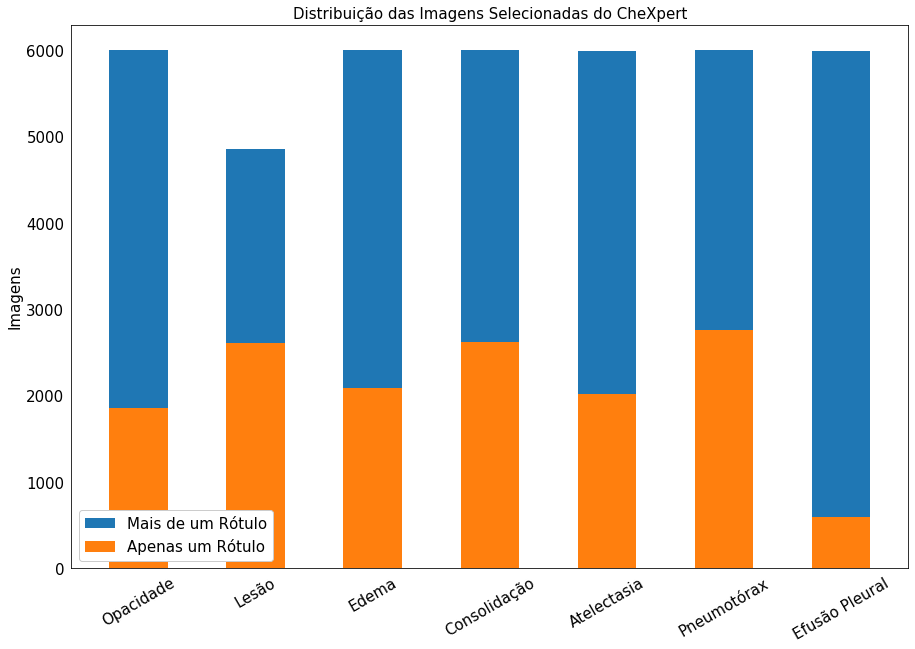

In [82]:
labels_tot = np.concatenate([train_gen.labels, valid_gen.labels, test_Y])

plt.figure(figsize=(15,10))
plt.xticks(rotation=30, size=15, )
plt.bar(x=labels_editada, height=np.sum(labels_tot, axis=0), width=0.5, label = 'Mais de um Rótulo')
plt.yticks(size=15)
plt.legend(fontsize=15, loc=3, framealpha=1)

data_analisys = pd.DataFrame(labels_tot)

individual_opacity = data_analisys[(data_analisys[0] == 1.) &
                                   (data_analisys[1] != 1.) &
                                   (data_analisys[2] != 1.) &
                                   (data_analisys[3] != 1.) &
                                   (data_analisys[4] != 1.) &
                                   (data_analisys[5] != 1.) &
                                   (data_analisys[6] != 1.)]

individual_lesion = data_analisys[(data_analisys[0] != 1.) &
                                  (data_analisys[1] == 1.) &
                                  (data_analisys[2] != 1.) &
                                  (data_analisys[3] != 1.) &
                                  (data_analisys[4] != 1.) &
                                  (data_analisys[5] != 1.) &
                                  (data_analisys[6] != 1.)]

individual_edema = data_analisys[(data_analisys[0] != 1.) &
                                 (data_analisys[1] != 1.) &
                                 (data_analisys[2] == 1.) &
                                 (data_analisys[3] != 1.) &
                                 (data_analisys[4] != 1.) &
                                 (data_analisys[5] != 1.) &
                                 (data_analisys[6] != 1.)]

individual_consolidation = data_analisys[(data_analisys[0] != 1.) &
                                         (data_analisys[1] != 1.) &
                                         (data_analisys[2] != 1.) &
                                         (data_analisys[3] == 1.) &
                                         (data_analisys[4] != 1.) &
                                         (data_analisys[5] != 1.) &
                                         (data_analisys[6] != 1.)]

individual_atelectasis = data_analisys[(data_analisys[0] != 1.) &
                                       (data_analisys[1] != 1.) &
                                       (data_analisys[2] != 1.) &
                                       (data_analisys[3] != 1.) &
                                       (data_analisys[4] == 1.) &
                                       (data_analisys[5] != 1.) &
                                       (data_analisys[6] != 1.)]

individual_pneumothorax = data_analisys[(data_analisys[0] != 1.) &
                                        (data_analisys[1] != 1.) &
                                        (data_analisys[2] != 1.) &
                                        (data_analisys[3] != 1.) &
                                        (data_analisys[4] != 1.) &
                                        (data_analisys[5] == 1.) &
                                        (data_analisys[6] != 1.)]

individual_effusion = data_analisys[(data_analisys[0] != 1.) &
                                    (data_analisys[1] != 1.) &
                                    (data_analisys[2] != 1.) &
                                    (data_analisys[3] != 1.) &
                                    (data_analisys[4] != 1.) &
                                    (data_analisys[5] != 1.) &
                                    (data_analisys[6] == 1.)]

individual = np.array([len(individual_opacity), len(individual_lesion),
                       len(individual_edema), len(individual_consolidation),
                       len(individual_atelectasis), len(individual_pneumothorax),
                       len(individual_effusion)])

plt.rcParams.update({'text.color': "black", 'axes.labelcolor': "black"})
plt.bar(x=labels_editada, height=individual, width=0.5, label = 'Apenas um Rótulo')
plt.legend(fontsize=15, loc=3, framealpha=1)
plt.title('Distribuição das Imagens Selecionadas do CheXpert', size=15, color = 'black')
plt.xticks(color = 'black')
plt.yticks(color = 'black')
plt.ylabel('Imagens', size=15, color = 'black')

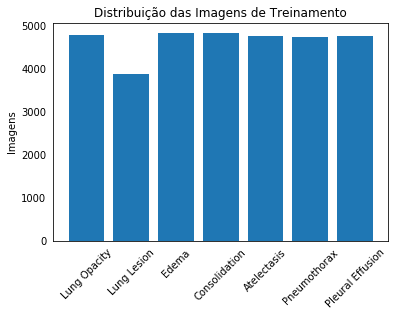

In [83]:
plt.xticks(rotation=45)
plt.bar(x=labels, height=np.sum(train_gen.labels, axis=0))
plt.title("Distribuição das Imagens de Treinamento")
plt.ylabel('Imagens')
plt.xticks(color = 'black')
plt.yticks(color = 'black')
plt.show()

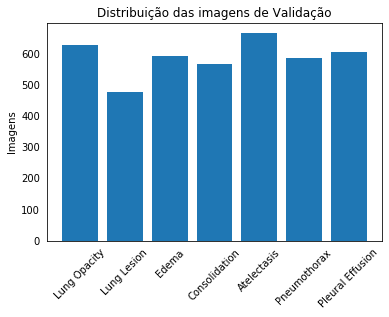

In [51]:
plt.xticks(rotation=45)
plt.bar(x=labels, height=np.sum(valid_gen.labels, axis=0))
plt.title("Distribuição das imagens de Validação")
plt.ylabel('Imagens')
plt.xticks(color = 'black')
plt.yticks(color = 'black')
plt.show()

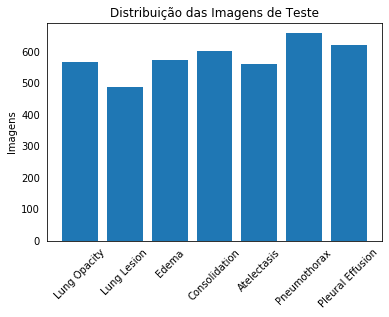

In [52]:
plt.xticks(rotation=45)
plt.bar(x=labels, height=np.sum(test_Y, axis=0))
plt.title("Distribuição das Imagens de Teste")
plt.ylabel('Imagens')
plt.xticks(color = 'black')
plt.yticks(color = 'black')
plt.show()

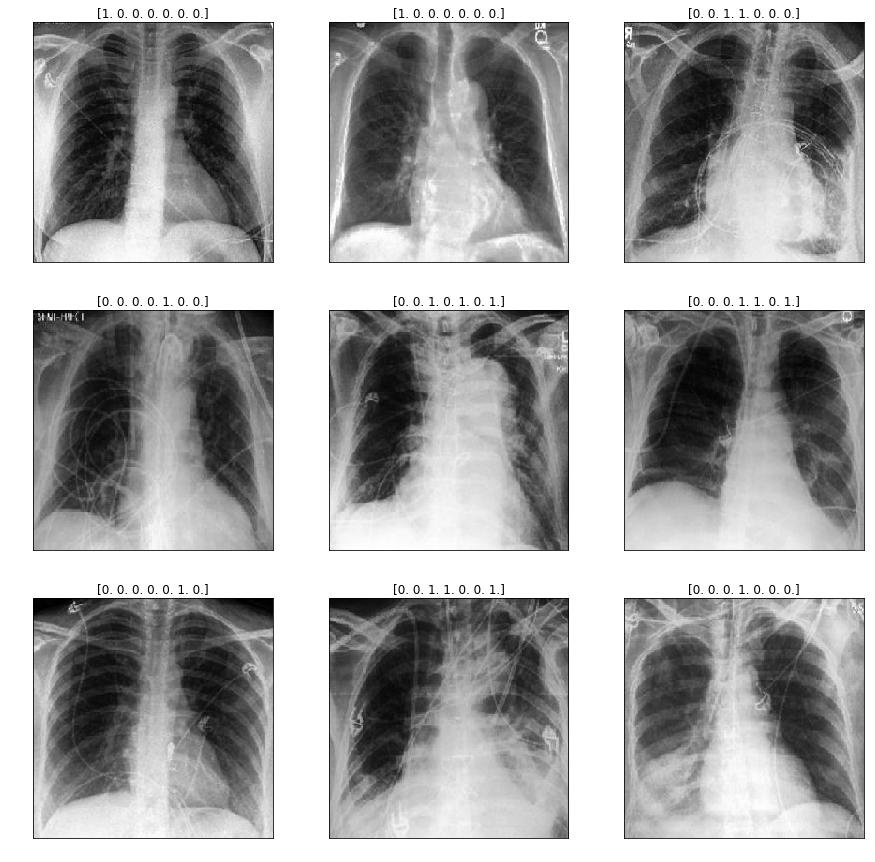

In [92]:
(x,y) = train_gen[1]
fig, axs = plt.subplots(3, 3, figsize = (15, 15))
count = 0
for i in range(0,3):
  for j in range(0,3):
    axs[i,j].set_title(str(y[count]))
    axs[i,j].imshow(x[count])
    count +=1

In [93]:
def get_callbacks(model_name, monitor = 'val_auc'):
    callbacks = []
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=f'model.{model_name}.h5',
                                                    verbose = 1, save_best_only = True, 
                                                    monitor = monitor, mode = 'max')
    callbacks.append(checkpoint)
    reducelr = tf.keras.callbacks.ReduceLROnPlateau(monitor = monitor, factor = 0.6, min_delta = 1e-5, 
                                                    patience = 2, verbose = 1, mode = 'max')
    callbacks.append(reducelr)
    return callbacks

### Modelo 1 - DenseNet121
***

In [95]:
base_model = DenseNet121(include_top = False, weights = 'imagenet', input_shape = (128, 128, 3))
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(rate = 0.3)(x)
output = tf.keras.layers.Dense(len(labels), activation = 'sigmoid')(x)
model_densenet = tf.keras.Model(base_model.input, output)
model_densenet.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
              loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.0), 
              metrics=[tf.keras.metrics.AUC(multi_label = True)])

callbacks = get_callbacks('densenet121', 'val_auc_9')
model_densenet.fit(train_gen,
              steps_per_epoch = len(train_df) / batch_size,
              validation_data= valid_gen,
              epochs = 10,
              callbacks=callbacks,
              use_multiprocessing = True, workers = 4)

Epoch 1/10
629/629 [==============================] - 184s 266ms/step - loss: 0.5030 - auc_9: 0.6871 - val_loss: 0.5555 - val_auc_9: 0.6944

Epoch 00001: val_auc_9 improved from -inf to 0.69436, saving model to model.densenet121.h5
Epoch 2/10
629/629 [==============================] - 164s 260ms/step - loss: 0.4781 - auc_9: 0.7254 - val_loss: 0.5499 - val_auc_9: 0.7108

Epoch 00002: val_auc_9 improved from 0.69436 to 0.71084, saving model to model.densenet121.h5
Epoch 3/10
629/629 [==============================] - 164s 259ms/step - loss: 0.4662 - auc_9: 0.7425 - val_loss: 0.7169 - val_auc_9: 0.6877

Epoch 00003: val_auc_9 did not improve from 0.71084
Epoch 4/10
230/629 [=========>....................] - ETA: 1:38 - loss: 0.4596 - auc_9: 0.7521

Process Keras_worker_ForkPoolWorker-384:
Traceback (most recent call last):
Process Keras_worker_ForkPoolWorker-382:
Process Keras_worker_ForkPoolWorker-385:
Process Keras_worker_ForkPoolWorker-383:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self

KeyboardInterrupt: ignored

In [155]:
model_densenet.load_weights('/content/model.densenet121.h5')

In [156]:
y_pred = model_densenet.predict(test_X)
model_densenet.evaluate(test_X, test_Y)

79/79 [==============================] - 8s 75ms/step - loss: 0.4523 - auc: 0.7732


[0.4522796869277954, 0.7732405066490173]

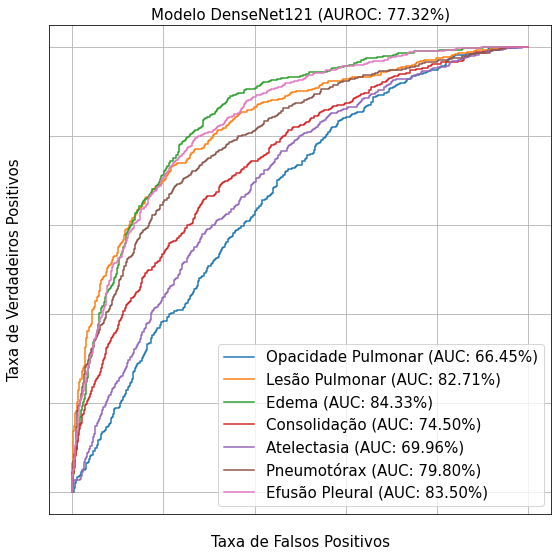

In [157]:
fig, c_ax = plt.subplots(1, 1, figsize=(9, 9))
for (idx, c_label) in enumerate(labels_portugues):
    fpr, tpr, thresholds = roc_curve(test_Y[:, idx].astype(int), y_pred[:, idx])
    c_ax.plot(fpr, tpr, label='{} (AUC: {:.2f}%)'.format(c_label, auc(fpr, tpr) * 100))
c_ax.legend(fontsize=15)
c_ax.set_xlabel('Taxa de Falsos Positivos', size=15)
c_ax.set_ylabel('Taxa de Verdadeiros Positivos', size=15)
c_ax.set_title('Modelo DenseNet121 (AUROC: ' + str(roc_auc_score(test_Y.astype(int), y_pred)*100)[0:5] + '%)', size=15)
c_ax.grid(True)

In [158]:
print('Erro Quadrático Médio: {:.2f}%'.format(mean_squared_error(test_Y, y_pred)*100))
print('Erro Absoluto Médio: {:.2f}%'.format(mean_absolute_error(test_Y, y_pred)*100))
print('AUROC: {:.2f}%'.format(roc_auc_score(test_Y.astype(int), y_pred)*100))

Erro Quadrático Médio: 14.52%
Erro Absoluto Médio: 27.01%
AUROC: 77.32%


### Modelo 2 - InceptionV3
***

In [161]:
base_model = InceptionV3(include_top = False, weights = 'imagenet', input_shape  =(256, 256, 3))
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
output = tf.keras.layers.Dense(len(labels), activation = 'sigmoid')(x)
model_inception = tf.keras.Model(base_model.input, output)
model_inception.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), 
                        loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.0), 
                        metrics=[tf.keras.metrics.AUC(multi_label = True)])

callbacks = get_callbacks('inceptionv3', 'val_auc_3')
model_inception.fit(train_gen,
                    steps_per_epoch = len(train_df) / batch_size,
                    validation_data = valid_gen,
                    epochs = 10,
                    callbacks=callbacks,
                    use_multiprocessing = True, workers = 8)

Epoch 1/10
629/629 [==============================] - 188s 280ms/step - loss: 0.4806 - auc_3: 0.7188 - val_loss: 0.4848 - val_auc_3: 0.7498

Epoch 00001: val_auc_3 improved from -inf to 0.74978, saving model to model.inceptionv3.h5
Epoch 2/10
629/629 [==============================] - 164s 255ms/step - loss: 0.4433 - auc_3: 0.7743 - val_loss: 0.4778 - val_auc_3: 0.7574

Epoch 00002: val_auc_3 improved from 0.74978 to 0.75743, saving model to model.inceptionv3.h5
Epoch 3/10
629/629 [==============================] - 163s 253ms/step - loss: 0.4192 - auc_3: 0.8027 - val_loss: 0.4619 - val_auc_3: 0.7673

Epoch 00003: val_auc_3 improved from 0.75743 to 0.76735, saving model to model.inceptionv3.h5
Epoch 4/10
629/629 [==============================] - 164s 254ms/step - loss: 0.3919 - auc_3: 0.8312 - val_loss: 0.4589 - val_auc_3: 0.7769

Epoch 00004: val_auc_3 improved from 0.76735 to 0.77695, saving model to model.inceptionv3.h5
Epoch 5/10
629/629 [==============================] - 161s 252m

In [162]:
model_inception.load_weights('/content/model.inceptionv3.h5')

In [163]:
y_pred = model_inception.predict(test_X)
model_inception.evaluate(test_X, test_Y)

79/79 [==============================] - 7s 62ms/step - loss: 0.5419 - auc_3: 0.7955


[0.541863203048706, 0.7954562306404114]

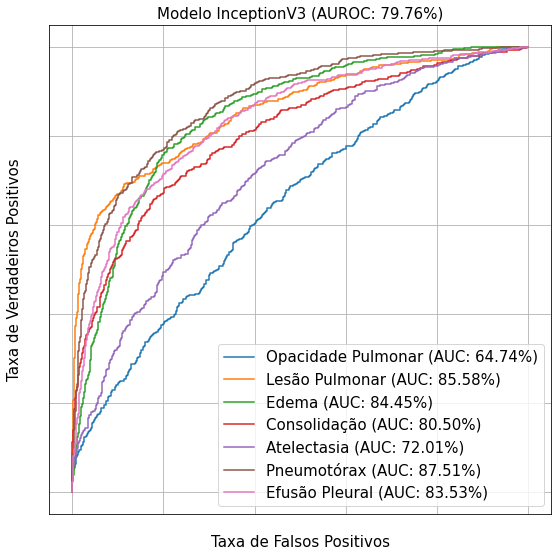

In [164]:
fig, c_ax = plt.subplots(1, 1, figsize=(9, 9))
for (idx, c_label) in enumerate(labels_portugues):
    fpr, tpr, thresholds = roc_curve(test_Y[:, idx].astype(int), y_pred[:, idx])
    c_ax.plot(fpr, tpr, label='{} (AUC: {:.2f}%)'.format(c_label, auc(fpr, tpr) * 100))
c_ax.legend(fontsize=15)
c_ax.set_xlabel('Taxa de Falsos Positivos', size=15)
c_ax.set_ylabel('Taxa de Verdadeiros Positivos', size=15)
c_ax.set_title('Modelo InceptionV3 (AUROC: ' + str(roc_auc_score(test_Y.astype(int), y_pred)*100)[0:5] + '%)', size=15)
c_ax.grid(True)

In [165]:
print('Erro Quadrático Médio: {:.2f}%'.format(mean_squared_error(test_Y, y_pred)*100))
print('Erro Absoluto Médio: {:.2f}%'.format(mean_absolute_error(test_Y, y_pred)*100))
print('AUROC: {:.2f}%'.format(roc_auc_score(test_Y.astype(int), y_pred)*100))

Erro Quadrático Médio: 14.86%
Erro Absoluto Médio: 22.17%
AUROC: 79.76%


### Modelo 3 - Xception
***

In [167]:
base_model = Xception(include_top = False, weights = 'imagenet', input_shape = (256, 256, 3))
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
output = tf.keras.layers.Dense(len(labels), activation = 'sigmoid')(x)
model_xception = tf.keras.Model(base_model.input, output)
model_xception.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), 
                       loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.0), 
                       metrics=[tf.keras.metrics.AUC(multi_label = True)])

callbacks = get_callbacks('xception', 'val_auc_5')
model_xception.fit(train_gen,
                   steps_per_epoch =  len(train_df) / batch_size,
                   validation_data = valid_gen,
                   epochs = 10,
                   callbacks = callbacks,
                   use_multiprocessing = True, workers = 8)

Epoch 1/10
629/629 [==============================] - 356s 551ms/step - loss: 0.4800 - auc_5: 0.7203 - val_loss: 0.4720 - val_auc_5: 0.7550

Epoch 00001: val_auc_5 improved from -inf to 0.75498, saving model to model.xception.h5
Epoch 2/10
629/629 [==============================] - 338s 531ms/step - loss: 0.4300 - auc_5: 0.7906 - val_loss: 0.4571 - val_auc_5: 0.7760

Epoch 00002: val_auc_5 improved from 0.75498 to 0.77602, saving model to model.xception.h5
Epoch 3/10
629/629 [==============================] - 338s 532ms/step - loss: 0.3891 - auc_5: 0.8338 - val_loss: 0.4508 - val_auc_5: 0.7837

Epoch 00003: val_auc_5 improved from 0.77602 to 0.78373, saving model to model.xception.h5
Epoch 4/10
629/629 [==============================] - 337s 531ms/step - loss: 0.3398 - auc_5: 0.8764 - val_loss: 0.4333 - val_auc_5: 0.7944

Epoch 00004: val_auc_5 improved from 0.78373 to 0.79438, saving model to model.xception.h5
Epoch 5/10
629/629 [==============================] - 337s 530ms/step - los

In [168]:
model_xception.load_weights('/content/model.xception.h5')

In [169]:
y_pred = model_xception.predict(test_X)
model_xception.evaluate(test_X, test_Y)

79/79 [==============================] - 9s 101ms/step - loss: 0.5456 - auc_5: 0.7992


[0.545615553855896, 0.7991970181465149]

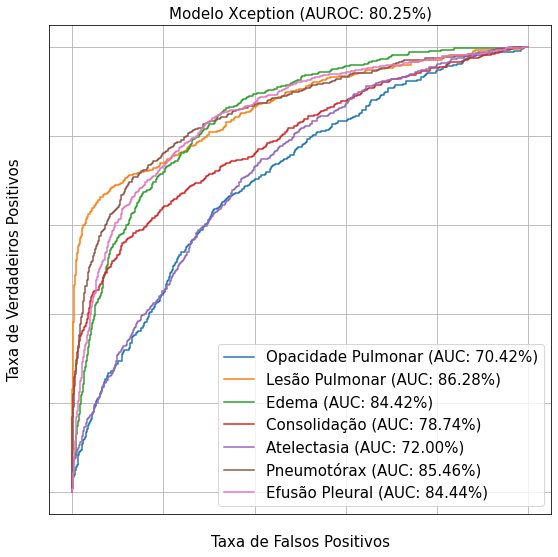

In [170]:
fig, c_ax = plt.subplots(1, 1, figsize=(9, 9))
for (idx, c_label) in enumerate(labels_portugues):
    fpr, tpr, thresholds = roc_curve(test_Y[:, idx].astype(int), y_pred[:, idx])
    c_ax.plot(fpr, tpr, label='{} (AUC: {:.2f}%)'.format(c_label, auc(fpr, tpr) * 100))
c_ax.legend(fontsize=15)
c_ax.set_xlabel('Taxa de Falsos Positivos', size=15)
c_ax.set_ylabel('Taxa de Verdadeiros Positivos', size=15)
c_ax.set_title('Modelo Xception (AUROC: ' + str(roc_auc_score(test_Y.astype(int), y_pred)*100)[0:5] + '%)', size=15)
c_ax.grid(True)

In [171]:
print('Erro Quadrático Médio: {:.2f}%'.format(mean_squared_error(test_Y, y_pred)*100))
print('Erro Absoluto Médio: {:.2f}%'.format(mean_absolute_error(test_Y, y_pred)*100))
print('AUROC: {:.2f}%'.format(roc_auc_score(test_Y.astype(int), y_pred)*100))

Erro Quadrático Médio: 14.65%
Erro Absoluto Médio: 21.45%
AUROC: 80.25%


### Modelo 4 - InceptionResNetV2
***

In [172]:
base_model = InceptionResNetV2(include_top = False, weights = 'imagenet', input_shape = (256, 256, 3))
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
output = tf.keras.layers.Dense(len(labels), activation = 'sigmoid')(x)
model_inceptionresnet = tf.keras.Model(base_model.input, output)
model_inceptionresnet.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), 
                       loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.0), 
                       metrics=[tf.keras.metrics.AUC(multi_label = True)])

callbacks = get_callbacks('inceptionresnet', 'val_auc_6')
model_inceptionresnet.fit(train_gen,
                          steps_per_epoch = len(train_df) / batch_size,
                          validation_data = valid_gen,
                          epochs = 10,
                          callbacks=callbacks,
                          use_multiprocessing = True, workers = 8)

219070464/219055592 [==============================] - 2s 0us/step
Epoch 1/10
629/629 [==============================] - 318s 463ms/step - loss: 0.4804 - auc_6: 0.7192 - val_loss: 0.4882 - val_auc_6: 0.7497

Epoch 00001: val_auc_6 improved from -inf to 0.74972, saving model to model.inceptionresnet.h5
Epoch 2/10
629/629 [==============================] - 289s 452ms/step - loss: 0.4349 - auc_6: 0.7846 - val_loss: 0.4528 - val_auc_6: 0.7765

Epoch 00002: val_auc_6 improved from 0.74972 to 0.77653, saving model to model.inceptionresnet.h5
Epoch 3/10
629/629 [==============================] - 288s 452ms/step - loss: 0.3974 - auc_6: 0.8244 - val_loss: 0.4399 - val_auc_6: 0.7897

Epoch 00003: val_auc_6 improved from 0.77653 to 0.78965, saving model to model.inceptionresnet.h5
Epoch 4/10
629/629 [==============================] - 287s 452ms/step - loss: 0.3549 - auc_6: 0.8632 - val_loss: 0.4512 - val_auc_6: 0.7998

Epoch 00004: val_auc_6 improved from 0.78965 to 0.79975, saving model to model

In [173]:
model_inceptionresnet.load_weights('/content/model.inceptionresnet.h5')

In [174]:
y_pred = model_inceptionresnet.predict(test_X)
model_inceptionresnet.evaluate(test_X, test_Y)

79/79 [==============================] - 15s 138ms/step - loss: 0.4773 - auc_6: 0.8026


[0.4773446321487427, 0.8026216626167297]

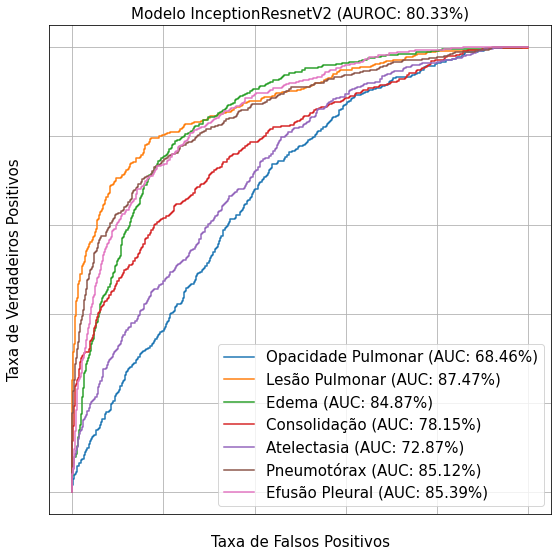

In [175]:
fig, c_ax = plt.subplots(1, 1, figsize=(9, 9))
for (idx, c_label) in enumerate(labels_portugues):
    fpr, tpr, thresholds = roc_curve(test_Y[:, idx].astype(int), y_pred[:, idx])
    c_ax.plot(fpr, tpr, label='{} (AUC: {:.2f}%)'.format(c_label, auc(fpr, tpr) * 100))
c_ax.legend(fontsize=15)
c_ax.set_xlabel('Taxa de Falsos Positivos', size=15)
c_ax.set_ylabel('Taxa de Verdadeiros Positivos', size=15)
c_ax.set_title('Modelo InceptionResnetV2 (AUROC: ' + str(roc_auc_score(test_Y.astype(int), y_pred)*100)[0:5] + '%)', size=15)
c_ax.grid(True)

In [176]:
print('Erro Quadrático Médio: {:.2f}%'.format(mean_squared_error(test_Y, y_pred)*100))
print('Erro Absoluto Médio: {:.2f}%'.format(mean_absolute_error(test_Y, y_pred)*100))
print('AUROC: {:.2f}%'.format(roc_auc_score(test_Y.astype(int), y_pred)*100))

Erro Quadrático Médio: 14.79%
Erro Absoluto Médio: 25.39%
AUROC: 80.33%


### Modelo 5 - VGG16
***

In [177]:
base_model = VGG16(include_top = False, weights = 'imagenet', input_shape = (256, 256, 3))
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
output = tf.keras.layers.Dense(len(labels), activation = 'sigmoid')(x)
model_vgg = tf.keras.Model(base_model.input, output)
model_vgg.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), 
                 loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.0), 
                 metrics = [tf.keras.metrics.AUC(multi_label = True)])

callbacks = get_callbacks('vgg16', 'val_auc_7')
model_vgg.fit(train_gen,
              steps_per_epoch = len(train_df) / batch_size,
              validation_data = valid_gen,
              epochs = 10,
              callbacks=callbacks, 
              use_multiprocessing = True, workers = 8)

58900480/58889256 [==============================] - 1s 0us/step
Epoch 1/10
629/629 [==============================] - 199s 301ms/step - loss: 0.5127 - auc_7: 0.6444 - val_loss: 0.4940 - val_auc_7: 0.6996

Epoch 00001: val_auc_7 improved from -inf to 0.69964, saving model to model.vgg16.h5
Epoch 2/10
629/629 [==============================] - 191s 296ms/step - loss: 0.4881 - auc_7: 0.7024 - val_loss: 0.4890 - val_auc_7: 0.7243

Epoch 00002: val_auc_7 improved from 0.69964 to 0.72427, saving model to model.vgg16.h5
Epoch 3/10
629/629 [==============================] - 188s 293ms/step - loss: 0.4772 - auc_7: 0.7230 - val_loss: 0.4749 - val_auc_7: 0.7372

Epoch 00003: val_auc_7 improved from 0.72427 to 0.73723, saving model to model.vgg16.h5
Epoch 4/10
629/629 [==============================] - 188s 293ms/step - loss: 0.4686 - auc_7: 0.7365 - val_loss: 0.4736 - val_auc_7: 0.7416

Epoch 00004: val_auc_7 improved from 0.73723 to 0.74161, saving model to model.vgg16.h5
Epoch 5/10
629/629 [==

In [178]:
model_vgg.load_weights('/content/model.vgg16.h5')

In [56]:
y_pred = model_vgg.predict(test_X)
model_vgg.evaluate(test_X, test_Y)

79/79 [==============================] - 7s 79ms/step - loss: 0.4583 - auc_7: 0.7767


[0.4583115577697754, 0.7767024636268616]

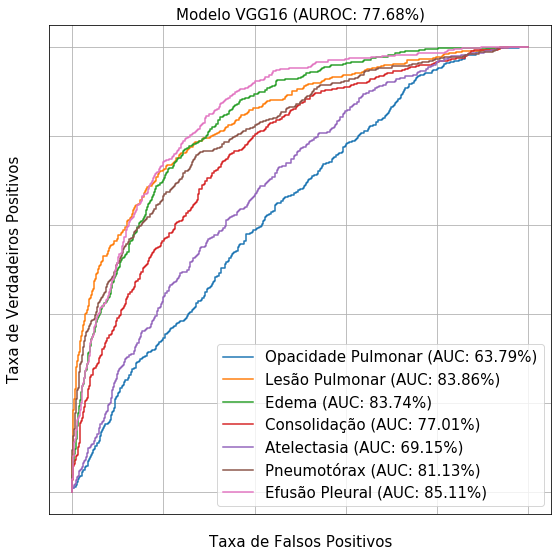

In [57]:
fig, c_ax = plt.subplots(1, 1, figsize=(9, 9))
for (idx, c_label) in enumerate(labels_portugues):
    fpr, tpr, thresholds = roc_curve(test_Y[:, idx].astype(int), y_pred[:, idx])
    c_ax.plot(fpr, tpr, label='{} (AUC: {:.2f}%)'.format(c_label, auc(fpr, tpr) * 100))
c_ax.legend(fontsize=15)
c_ax.set_xlabel('Taxa de Falsos Positivos', size=15)
c_ax.set_ylabel('Taxa de Verdadeiros Positivos', size=15)
c_ax.set_title('Modelo VGG16 (AUROC: ' + str(roc_auc_score(test_Y.astype(int), y_pred)*100)[0:5] + '%)', size=15)
c_ax.grid(True)

In [58]:
print('Erro Quadrático Médio: {:.2f}%'.format(mean_squared_error(test_Y, y_pred)*100))
print('Erro Absoluto Médio: {:.2f}%'.format(mean_absolute_error(test_Y, y_pred)*100))
print('AUROC: {:.2f}%'.format(roc_auc_score(test_Y.astype(int), y_pred)*100))

Erro Quadrático Médio: 14.72%
Erro Absoluto Médio: 28.58%
AUROC: 77.68%


### Modelo 6 - ResNet101V2
***

In [59]:
base_model = ResNet101V2(include_top = False, weights = 'imagenet', input_shape = (256, 256, 3))
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
output = tf.keras.layers.Dense(len(labels), activation = 'sigmoid')(x)
model_resnet = tf.keras.Model(base_model.input, output)
model_resnet.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), 
                     loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.0), 
                     metrics = [tf.keras.metrics.AUC(multi_label = True)])

callbacks = get_callbacks('resnet101v2', 'val_auc_8')
model_resnet.fit(train_gen,
                 steps_per_epoch = len(train_df) / batch_size,
                 validation_data = valid_gen,
                 epochs = 10,
                 callbacks=callbacks, 
                 use_multiprocessing = True, workers = 8)

171327488/171317808 [==============================] - 2s 0us/step
Epoch 1/10
468/629 [=====================>........] - ETA: 1:12 - loss: 0.4879 - auc: 0.7062

Process Keras_worker_ForkPoolWorker-4:
Process Keras_worker_ForkPoolWorker-1:
Process Keras_worker_ForkPoolWorker-8:
Traceback (most recent call last):
Traceback (most recent call last):
Process Keras_worker_ForkPoolWorker-5:
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Process Keras_worker_ForkPoolWorker-6:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Process Keras_worker_ForkPoolWorker-2:
  File "/usr/lib/python3.7/multiprocessing/pool.py", line 127, in worker
    put((job, i, result))
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 364, in put
    self._writer.send_bytes(obj)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwar

KeyboardInterrupt: ignored

In [ ]:
model_resnet.load_weights('/content/model.resnet101v2.h5')

In [ ]:
y_pred = model_resnet.predict(test_X)
model_resnet.evaluate(test_X, test_Y)

In [ ]:
fig, c_ax = plt.subplots(1, 1, figsize=(9, 9))
for (idx, c_label) in enumerate(labels_portugues):
    fpr, tpr, thresholds = roc_curve(test_Y[:, idx].astype(int), y_pred[:, idx])
    c_ax.plot(fpr, tpr, label='{} (AUC: {:.2f}%)'.format(c_label, auc(fpr, tpr) * 100))
c_ax.legend(fontsize=15)
c_ax.set_xlabel('Taxa de Falsos Positivos', size=15)
c_ax.set_ylabel('Taxa de Verdadeiros Positivos', size=15)
c_ax.set_title('Modelo ResNet101V2 (AUROC: ' + str(roc_auc_score(test_Y.astype(int), y_pred)*100)[0:5] + '%)', size=15)
c_ax.grid(True)

In [ ]:
print('Erro Quadrático Médio: {:.2f}%'.format(mean_squared_error(test_Y, y_pred)*100))
print('Erro Absoluto Médio: {:.2f}%'.format(mean_absolute_error(test_Y, y_pred)*100))
print('AUROC: {:.2f}%'.format(roc_auc_score(test_Y.astype(int), y_pred)*100))

### Modelo 7 - MobileNetV2
***

In [ ]:
base_model = MobileNetV2(include_top = False, weights = 'imagenet', input_shape = (256, 256, 3))
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
output = tf.keras.layers.Dense(len(labels), activation = 'sigmoid')(x)
model_mobilenet = tf.keras.Model(base_model.input, output)
model_mobilenet.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), 
                        loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.0), 
                        metrics = [tf.keras.metrics.AUC(multi_label = True)])

callbacks = get_callbacks('mobilenetv2', 'val_auc_9')
model_mobilenet.fit(train_gen,
                    steps_per_epoch = len(train_df) / batch_size,
                    validation_data = valid_gen,
                    epochs = 10,
                    callbacks=callbacks, 
                    use_multiprocessing = True, workers = 8)

In [ ]:
model_mobilenet.load_weights('/content/model.mobilenetv2.h5')

In [ ]:
y_pred = model_mobilenet.predict(test_X)
model_mobilenet.evaluate(test_X, test_Y)

In [ ]:
fig, c_ax = plt.subplots(1, 1, figsize=(9, 9))
for (idx, c_label) in enumerate(labels_portugues):
    fpr, tpr, thresholds = roc_curve(test_Y[:, idx].astype(int), y_pred[:, idx])
    c_ax.plot(fpr, tpr, label='{} (AUC: {:.2f}%)'.format(c_label, auc(fpr, tpr) * 100))
c_ax.legend(fontsize=15)
c_ax.set_xlabel('Taxa de Falsos Positivos', size=15)
c_ax.set_ylabel('Taxa de Verdadeiros Positivos', size=15)
c_ax.set_title('Modelo MobileNetV2 (AUROC: ' + str(roc_auc_score(test_Y.astype(int), y_pred)*100)[0:5] + '%)', size=15)
c_ax.grid(True)

In [ ]:
print('Erro Quadrático Médio: {:.2f}%'.format(mean_squared_error(test_Y, y_pred)*100))
print('Erro Absoluto Médio: {:.2f}%'.format(mean_absolute_error(test_Y, y_pred)*100))
print('AUROC: {:.2f}%'.format(roc_auc_score(test_Y.astype(int), y_pred)*100))

### Média Ponderada - Estratégia de Comitê
***

**NOTA**: Os rótulos verdadeiros do algoritmo foram utilizados  para fins de computar o valor de AUROC, esses que se mantém constantes desde a finalização do treinamento dos algoritmos.

In [ ]:
def weighted_average(zip_labels, true_label):
  
  y_pred1, y_pred2, y_pred3, y_pred4, y_pred5, y_pred6, y_pred7 = zip(*zip_labels)

  y_pred1, y_pred2, y_pred3, y_pred4, y_pred5, y_pred6, y_pred7 = np.array(y_pred1), np.array(y_pred2), np.array(y_pred3), np.array(y_pred4), np.array(y_pred5), np.array(y_pred6), np.array(y_pred7)

  y_pred = (y_pred1 * roc_auc_score(true_label.astype(int), y_pred1) + y_pred2 * roc_auc_score(true_label.astype(int), y_pred2) + y_pred3 * roc_auc_score(true_label.astype(int), y_pred3) + y_pred4 * roc_auc_score(true_label.astype(int), y_pred4) + y_pred5 * roc_auc_score(true_label.astype(int), y_pred5) + y_pred6 * roc_auc_score(true_label.astype(int), y_pred6) + y_pred7 * roc_auc_score(true_label.astype(int), y_pred7)) / 7

  return y_pred

In [ ]:
y_pred1 = model_densenet.predict(test_X)
y_pred2 = model_inception.predict(test_X)
y_pred3 = model_xception.predict(test_X)
y_pred4 = model_inceptionresnet.predict(test_X)
y_pred5 = model_vgg.predict(test_X)
y_pred6 = model_resnet.predict(test_X)
y_pred7 = model_mobilenet.predict(test_X)

zip_labels = zip(y_pred1, y_pred2, y_pred3, y_pred4, y_pred5, y_pred6, y_pred7)

In [ ]:
y_pred = weighted_average(zip_labels, test_Y)

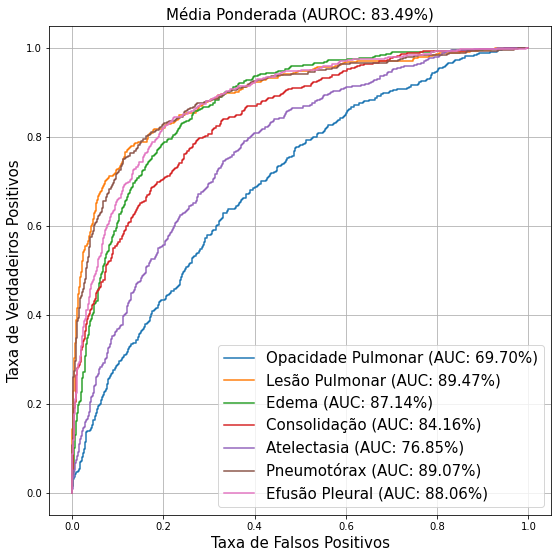

In [ ]:
fig, c_ax = plt.subplots(1, 1, figsize=(9, 9))
for (idx, c_label) in enumerate(labels_portugues):
    fpr, tpr, thresholds = roc_curve(test_Y[:, idx].astype(int), y_pred[:, idx])
    c_ax.plot(fpr, tpr, label='{} (AUC: {:.2f}%)'.format(c_label, auc(fpr, tpr) * 100))
c_ax.legend(fontsize=15)
c_ax.set_xlabel('Taxa de Falsos Positivos', size=15)
c_ax.set_ylabel('Taxa de Verdadeiros Positivos', size=15)
c_ax.set_title('Média Ponderada (AUROC: ' + str(roc_auc_score(test_Y.astype(int), y_pred)*100)[0:5] + '%)', size=15)
c_ax.grid(True)

In [ ]:
print('Erro Quadrático Médio: {:.2f}%'.format(mean_squared_error(test_Y, y_pred)*100))
print('Erro Absoluto Médio: {:.2f}%'.format(mean_absolute_error(test_Y, y_pred)*100))
print('AUROC: {:.2f}%'.format(roc_auc_score(test_Y.astype(int), y_pred)*100))

Erro Quadrático Médio: 12.87%
Erro Absoluto Médio: 24.30%
AUROC: 83.49%


### Média Simples - Estratégia de Comitê
***

In [ ]:
def average(zip_labels):
  
  y_pred1, y_pred2, y_pred3, y_pred4, y_pred5, y_pred6, y_pred7 = zip(*zip_labels)

  y_pred1, y_pred2, y_pred3, y_pred4, y_pred5, y_pred6, y_pred7 = np.array(y_pred1), np.array(y_pred2), np.array(y_pred3), np.array(y_pred4), np.array(y_pred5), np.array(y_pred6), np.array(y_pred7)

  y_pred = (y_pred1 + y_pred2 + y_pred3 + y_pred4 + y_pred5 + y_pred6 + y_pred7) / 7

  return y_pred

In [ ]:
y_pred1 = model_densenet.predict(test_X)
y_pred2 = model_inception.predict(test_X)
y_pred3 = model_xception.predict(test_X)
y_pred4 = model_inceptionresnet.predict(test_X)
y_pred5 = model_vgg.predict(test_X)
y_pred6 = model_resnet.predict(test_X)
y_pred7 = model_mobilenet.predict(test_X)

zip_labels = zip(y_pred1, y_pred2, y_pred3, y_pred4, y_pred5, y_pred6, y_pred7)

In [ ]:
y_pred = average(zip_labels)

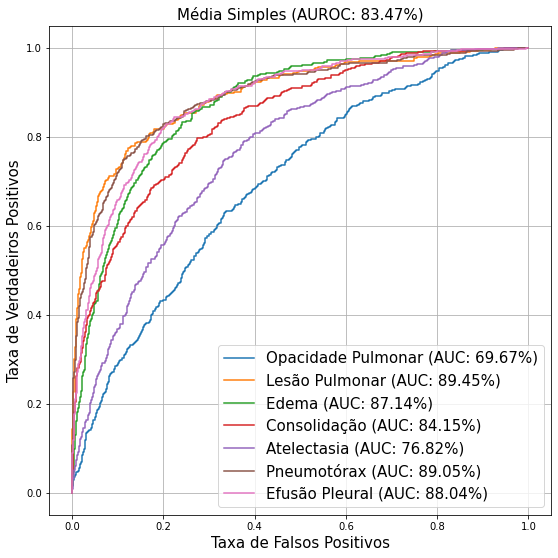

In [ ]:
fig, c_ax = plt.subplots(1, 1, figsize=(9, 9))
for (idx, c_label) in enumerate(labels_portugues):
    fpr, tpr, thresholds = roc_curve(test_Y[:, idx].astype(int), y_pred[:, idx])
    c_ax.plot(fpr, tpr, label='{} (AUC: {:.2f}%)'.format(c_label, auc(fpr, tpr) * 100))
c_ax.legend(fontsize=15)
c_ax.set_xlabel('Taxa de Falsos Positivos', size=15)
c_ax.set_ylabel('Taxa de Verdadeiros Positivos', size=15)
c_ax.set_title('Média Simples (AUROC: ' + str(roc_auc_score(test_Y.astype(int), y_pred)*100)[0:5] + '%)', size=15)
c_ax.grid(True)

# OBSERVAÇÃO: os resultados não se mostraram superiores a média ponderada

### Voto da Maioria - Estratégia de Comitê
***

**NOTA**: Os rótulos verdadeiros do algoritmo foram utilizados  para fins de computar o valor de AUROC, esses que se mantém constantes desde a finalização do treinamento dos algoritmos.

In [ ]:
def threshold_label(label, threshold):

  binarize_label = np.zeros(label.shape)
  for i in range(0, len(label)):
    if label[i] >= threshold:
      binarize_label[i] = 1
  
  return binarize_label

def threshold_labels(labels, threshold):

  binarize_labels = np.zeros(labels.shape)
  for i in range (0, len(labels)):
    binarize_labels[i] = threshold_label(labels[i], threshold)

  return binarize_labels

def count_frequency(zip_labels):

  (pred1, pred2, pred3, pred4, pred5, pred6, pred7) = zip(*zip_labels)

  frequency = np.sum([np.array(pred1), np.array(pred2), np.array(pred3), np.array(pred4), np.array(pred5), np.array(pred6), np.array(pred7)], axis=0)

  return frequency
 
def majority_vote(frequency, threshold_vote, zip_continuous, test_Y):

  (y_pred1, y_pred2, y_pred3, y_pred4, y_pred5, y_pred6, y_pred7) = zip(*zip_continuous)
  zip_continuous = zip(y_pred1, y_pred2, y_pred3, y_pred4, y_pred5, y_pred6, y_pred7)
  mp = weighted_average(zip_continuous, test_Y)

  majority = np.zeros((frequency.shape))
  for i in range(0, len(frequency)):
    flatten_columns = np.squeeze(np.array([[y_pred1[i]], [y_pred2[i]], [y_pred3[i]], [y_pred4[i]],[y_pred5[i]], [y_pred6[i]], [y_pred7[i]]]))
    indexes = np.argmax(flatten_columns, axis=0)
    for j in range(0, frequency.shape[1]):
      if frequency[i][j] >= threshold_vote:
        majority[i][j] = flatten_columns[indexes[j]][j]
      else:
        majority[i][j] = mp[i][j]
        
  return majority

In [ ]:
y_pred1 = model_densenet.predict(test_X)
y_pred2 = model_inception.predict(test_X)
y_pred3 = model_xception.predict(test_X)
y_pred4 = model_inceptionresnet.predict(test_X)
y_pred5 = model_vgg.predict(test_X)
y_pred6 = model_resnet.predict(test_X)
y_pred7 = model_mobilenet.predict(test_X)

In [ ]:
for i in range (0, 100):
  for j in range (1, 8):
    threshold = i / 100
    threshold_vote = j
    y_pred1_bin = threshold_labels(y_pred1, threshold)
    y_pred2_bin = threshold_labels(y_pred2, threshold)
    y_pred3_bin = threshold_labels(y_pred3, threshold)
    y_pred4_bin = threshold_labels(y_pred4, threshold)
    y_pred5_bin = threshold_labels(y_pred5, threshold)
    y_pred6_bin = threshold_labels(y_pred6, threshold)
    y_pred7_bin = threshold_labels(y_pred7, threshold)

    zip_labels = zip(y_pred1_bin, y_pred2_bin, y_pred3_bin, y_pred4_bin, y_pred5_bin, y_pred6_bin, y_pred7_bin)
    zip_continuous = zip(y_pred1, y_pred2, y_pred3, y_pred4, y_pred5, y_pred6, y_pred7)
    frequency = count_frequency(zip_labels)
    y_pred_mv = majority_vote(frequency, threshold_vote, zip_continuous, test_Y)
   
    print('{}, {}: {}'.format(i/100, j, roc_auc_score(test_Y.astype(int), y_pred_mv)))

0.0, 1: 0.8214212083285757
0.0, 2: 0.8214212083285757
0.0, 3: 0.8214212083285757
0.0, 4: 0.8214212083285757
0.0, 5: 0.8214212083285757
0.0, 6: 0.8214212083285757
0.0, 7: 0.8214212083285757
0.01, 1: 0.8214109610804101
0.01, 2: 0.8214655379149383
0.01, 3: 0.8218112107452997
0.01, 4: 0.8217670319833228
0.01, 5: 0.8241958147742466
0.01, 6: 0.8261509580588902
0.01, 7: 0.8284910060722648
0.02, 1: 0.8214087328758292
0.02, 2: 0.8217731822558575
0.02, 3: 0.8221482309547651
0.02, 4: 0.8232261582615187
0.02, 5: 0.8256817329848571
0.02, 6: 0.8275439268193827
0.02, 7: 0.8302678941605299
0.03, 1: 0.8214065619593897
0.03, 2: 0.8219882193074259
0.03, 3: 0.8228876493852132
0.03, 4: 0.8243766645172986
0.03, 5: 0.8262328487819198
0.03, 6: 0.8285340697534795
0.03, 7: 0.8314828965105131
0.04, 1: 0.8214120747899403
0.04, 2: 0.8222888287463567
0.04, 3: 0.8232275241000684
0.04, 4: 0.8251710994574118
0.04, 5: 0.82704987643329
0.04, 6: 0.8299877174848476
0.04, 7: 0.8324080372611672
0.05, 1: 0.8214127769378827
0

In [ ]:
def majority_vote(frequency, threshold_vote, zip_continuous):

  (y_pred1, y_pred2, y_pred3, y_pred4, y_pred5, y_pred6, y_pred7) = zip(*zip_continuous)

  majority = np.zeros((frequency.shape))
  for i in range(0, len(frequency)):
    flatten_columns = np.squeeze(np.array([[y_pred1[i]], [y_pred2[i]], [y_pred3[i]], [y_pred4[i]],[y_pred5[i]], [y_pred6[i]], [y_pred7[i]]]))
    indexes = np.argmax(flatten_columns, axis=0)
    for j in range(0, frequency.shape[1]):
      if frequency[i][j] >= threshold_vote:
        majority[i][j] = flatten_columns[indexes[j]][j]
      else:
        majority[i][j] = 0
        
  return majority

In [ ]:
for i in range (0, 100):
  for j in range (1, 8):
    threshold = i / 100
    threshold_vote = j
    y_pred1_bin = threshold_labels(y_pred1, threshold)
    y_pred2_bin = threshold_labels(y_pred2, threshold)
    y_pred3_bin = threshold_labels(y_pred3, threshold)
    y_pred4_bin = threshold_labels(y_pred4, threshold)
    y_pred5_bin = threshold_labels(y_pred5, threshold)
    y_pred6_bin = threshold_labels(y_pred6, threshold)
    y_pred7_bin = threshold_labels(y_pred7, threshold)

    zip_labels = zip(y_pred1_bin, y_pred2_bin, y_pred3_bin, y_pred4_bin, y_pred5_bin, y_pred6_bin, y_pred7_bin)
    zip_continuous = zip(y_pred1, y_pred2, y_pred3, y_pred4, y_pred5, y_pred6, y_pred7)
    frequency = count_frequency(zip_labels)
    y_pred_mv = majority_vote(frequency, threshold_vote, zip_continuous)
   
    print('{}, {}: {}'.format(i/100, j, roc_auc_score(test_Y.astype(int), y_pred_mv)))

0.0, 1: 0.8214212083285757
0.0, 2: 0.8214212083285757
0.0, 3: 0.8214212083285757
0.0, 4: 0.8214212083285757
0.0, 5: 0.8214212083285757
0.0, 6: 0.8214212083285757
0.0, 7: 0.8214212083285757
0.01, 1: 0.8214156363873857
0.01, 2: 0.8214375583252238
0.01, 3: 0.8218097909906233
0.01, 4: 0.8213320269228225
0.01, 5: 0.8230270770640639
0.01, 6: 0.8190583294154042
0.01, 7: 0.7939594372356777
0.02, 1: 0.8213765032787161
0.02, 2: 0.8217592032424296
0.02, 3: 0.821834624301751
0.02, 4: 0.8220718458515329
0.02, 5: 0.8222058216103806
0.02, 6: 0.813058317638193
0.02, 7: 0.778562477237885
0.03, 1: 0.8213232051565822
0.03, 2: 0.821819894644201
0.03, 3: 0.8224469605675508
0.03, 4: 0.8219658051699689
0.03, 5: 0.8194144245225647
0.03, 6: 0.8067816614195765
0.03, 7: 0.76582214663323
0.04, 1: 0.8213521670833314
0.04, 2: 0.8220436505975697
0.04, 3: 0.8219564585961853
0.04, 4: 0.8213799120935078
0.04, 5: 0.8166894769420271
0.04, 6: 0.8018210550618494
0.04, 7: 0.7529275408716913
0.05, 1: 0.8212991571934015
0.05,

### Tempo de Inferência (ms)
***

In [ ]:
import time

In [ ]:
image = test_X[0].reshape(1,256,256,3)

In [ ]:
start_time = time.time()
model_densenet.predict(image)
end_time = time.time()

print('Tempo de Inferência: {}'.format(end_time - start_time))

Tempo de Inferência: 0.06946539878845215


In [ ]:
start_time = time.time()
model_inception.predict(image)
end_time = time.time()

print('Tempo de Inferência: {}'.format(end_time - start_time))

Tempo de Inferência: 0.05205512046813965


In [ ]:
start_time = time.time()
model_xception.predict(image)
end_time = time.time()

print('Tempo de Inferência: {}'.format(end_time - start_time))

Tempo de Inferência: 0.04483962059020996


In [ ]:
start_time = time.time()
model_inceptionresnet.predict(image)
end_time = time.time()

print('Tempo de Inferência: {}'.format(end_time - start_time))

Tempo de Inferência: 0.06449627876281738


In [ ]:
start_time = time.time()
model_vgg.predict(image)
end_time = time.time()

print('Tempo de Inferência: {}'.format(end_time - start_time))

Tempo de Inferência: 0.041649818420410156


In [ ]:
start_time = time.time()
model_resnet.predict(image)
end_time = time.time()

print('Tempo de Inferência: {}'.format(end_time - start_time))

Tempo de Inferência: 0.05455327033996582


In [ ]:
start_time = time.time()
model_mobilenet.predict(image)
end_time = time.time()

print('Tempo de Inferência: {}'.format(end_time - start_time))

Tempo de Inferência: 0.047670841217041016


In [ ]:
start_time = time.time()
y_pred1 = model_densenet.predict(image)
y_pred2 = model_inception.predict(image)
y_pred3 = model_xception.predict(image)
y_pred4 = model_inceptionresnet.predict(image)
y_pred5 = model_vgg.predict(image)
y_pred6 = model_resnet.predict(image)
y_pred7 = model_mobilenet.predict(image)
y_pred = (y_pred1 * 0.754 + y_pred2 * 0.755 + y_pred3 * 0.762 + y_pred4 * 0.762 + y_pred5 * 0.760 + y_pred6 * 0.749 + y_pred7 * 0.73) / 7
end_time = time.time()

print('Tempo de Inferência: {}'.format(end_time - start_time))

Tempo de Inferência: 0.3367161750793457


In [ ]:
start_time = time.time()
y_pred1 = model_densenet.predict(image)
y_pred2 = model_inception.predict(image)
y_pred3 = model_xception.predict(image)
y_pred4 = model_inceptionresnet.predict(image)
y_pred5 = model_vgg.predict(image)
y_pred6 = model_resnet.predict(image)
y_pred7 = model_mobilenet.predict(image)
y_pred = (y_pred1 + y_pred2 + y_pred3 + y_pred4 + y_pred5 + y_pred6 + y_pred7) / 7
end_time = time.time()

print('Tempo de Inferência: {}'.format(end_time - start_time))

Tempo de Inferência: 0.30196118354797363


### Comparação Ilustrativa dos resultados
***

In [ ]:
auc_densenet = [63.55, 81.12, 82.86, 74.62, 68.87, 81.67, 84.84]
auc_inception = [61.83, 86.47, 83.64, 77.21, 71.82, 86.31, 84.23]
auc_xception = [63.47, 86.63, 83.91, 81.25, 72.36, 84.90, 84.41]
auc_inceptionresnet = [67.69, 88.26, 85.17, 79.68, 72.94, 86.17, 84.71]
auc_vgg = [62.06, 83.62, 82.95, 77.01, 69.74, 83.96, 84.98]
auc_resnet = [63.86, 85.65, 84.49, 79.44, 70.72, 83.68, 84.90]
auc_mobilenet = [63.35, 82.60, 83.15, 74.53, 67.02, 82.04, 79.86]
auc_media_simples = [69.67, 89.45, 87.14, 84.15, 76.82, 89.05, 88.04]
auc_media_ponderada = [69.70, 89.47, 87.14, 84.16, 76.85, 89.07, 88.06]

Text(0.5, 1.0, 'Valores de AUC para cada uma das classes')

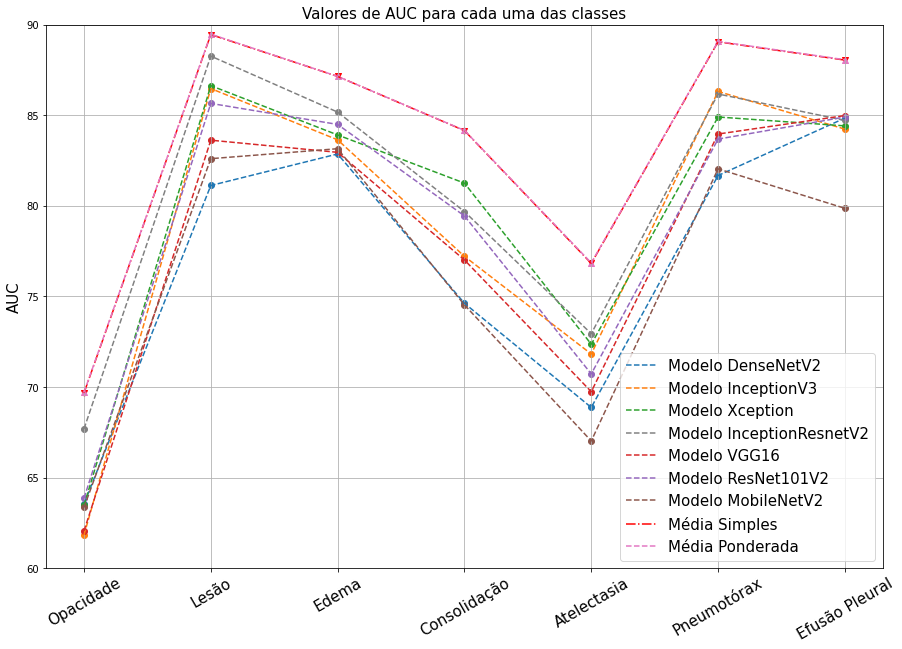

In [ ]:
plt.figure(figsize=(15,10))
plt.xticks(rotation=30, size=15)
plt.ylabel('AUC', size=15)
plt.ylim((60,90))
plt.scatter(labels_editada,auc_densenet)
plt.plot(labels_editada,auc_densenet, '--', label='Modelo DenseNetV2')
plt.scatter(labels_editada,auc_inception)
plt.plot(labels_editada,auc_inception, '--', label='Modelo InceptionV3')
plt.scatter(labels_editada,auc_xception)
plt.plot(labels_editada,auc_xception, '--', label='Modelo Xception')
plt.scatter(labels_editada,auc_inceptionresnet, color='grey')
plt.plot(labels_editada,auc_inceptionresnet, '--', label='Modelo InceptionResnetV2', color='grey')
plt.scatter(labels_editada,auc_vgg)
plt.plot(labels_editada,auc_vgg, '--', label='Modelo VGG16')
plt.scatter(labels_editada,auc_resnet)
plt.plot(labels_editada,auc_resnet, '--', label='Modelo ResNet101V2')
plt.scatter(labels_editada,auc_mobilenet)
plt.plot(labels_editada,auc_mobilenet, '--', label='Modelo MobileNetV2')
plt.scatter(labels_editada,auc_media_simples, marker='v', color='red')
plt.plot(labels_editada,auc_media_simples, '-.', label='Média Simples', color='red')
plt.scatter(labels_editada,auc_media_ponderada, marker = '^')
plt.plot(labels_editada,auc_media_ponderada, '--', label='Média Ponderada')
plt.grid()
plt.legend(fontsize=15)
plt.title('Valores de AUC para cada uma das classes', size=15)